In [6]:
import numpy as np
import netCDF4 as nc
import pandas as pd 
import os 
import datetime as dt 
import matplotlib.pyplot as plt 

In [2]:
def locate_file(d_str,path): 
    """
    function to locate TROPOMI level-2 data file based on datetime string  
    
    param: d_str-> datetime string (e.g., 20210101)
    param: path -> folder path for searching TROPOMI data files
    
    """
    files=[]
    for r, d, f in os.walk(path):
        for file in f:
            a = file.split('_')
            qaue_time = a[8] 
            if d_str in qaue_time:
                files.append(os.path.join(r, file))
    return files 

In [4]:
longitudes = np.arange(-180,180,0.1)
latitudes = np.arange(-90,90,0.1)
X,Y = np.meshgrid(longitudes,latitudes)

In [5]:
rav_lon = np.ravel(X)
rav_lat = np.ravel(Y)
rav_lat = np.round(rav_lat,decimals=1)
rav_lon = np.round(rav_lon,decimals=1)
rav_lon = rav_lon.astype(str)
rav_lat = rav_lat.astype(str)


### This is an example of calculating cloud cover induced TOC-reducing days between 2021 and 2022

In [ ]:
daytime = dt.datetime(2021,1,1)
mdf = pd.DataFrame(data={'lon':rav_lon,
                        'lat':rav_lat,
                        })

odf = pd.DataFrame(data={'lon':rav_lon,
                        'lat':rav_lat})

path = r"where you save your TROPOMI Level-2 data products"

while daytime.year<2022: 
    day_str = daytime.strftime("%Y%m%d")
    day_files = locate_file(day_str,path)
    print(day_str,len(day_files))
    i = 0 
    for f in day_files: 
        TF = nc.Dataset(f,'r')
        data = TF.groups['PRODUCT']
        var = TF.groups['PRODUCT'].variables
        
        CF1 = data['SUPPORT_DATA']['INPUT_DATA']['cloud_fraction_VIIRS_SWIR_IFOV'][0,:,:].data
        
        filt = CF1 == 9.96921e+36
        CF1[filt] = -1 
        
        CF = np.round(CF1,2)

        lat = var['latitude'][0,:,:].data
        lon = var['longitude'][0,:,:].data

        TF.close()
        
        
        # find grid cells with cloud fraction > 0  
        mask = CF >0 
        valid_cf = CF[mask]
        valid_lat = lat[mask]
        valid_lon = lon[mask]
        
        ones = np.ones(len(valid_lon))
        
        valid_lat = np.round(valid_lat,decimals=1)
        valid_lon = np.round(valid_lon,decimals=1)
        valid_lat  = valid_lat.astype(str)
        valid_lon = valid_lon.astype(str)

        df1 = pd.DataFrame(data={'lon':valid_lon,
                            'lat':valid_lat,
                            'cloud_{}'.format(i):ones})

        
        odf = pd.merge(odf, df1, on=['lon', 'lat'],how='left')
        odf.drop_duplicates(inplace=True)
        
        # find grid cells with cloud fraction = 0   
        mask2 = CF == 0 
        nd_sas = CF[mask2]
        nd_lat = lat[mask2]
        nd_lon = lon[mask2]
        
        ones2 = np.ones(len(nd_sas))
        
        nd_lat = np.round(nd_lat,decimals=1)
        nd_lon = np.round(nd_lon,decimals=1)
        nd_lat  = nd_lat.astype(str)
        nd_lon = nd_lon.astype(str)
        
        
        df2 = pd.DataFrame(data={'lon':nd_lon,
                            'lat':nd_lat,
                            'sza_{}'.format(i):ones2})
    
        mdf = pd.merge(mdf,df2,on=['lon', 'lat'],how='left')
        mdf.drop_duplicates(inplace=True)
        
        i += 1 

    day = odf.iloc[:,2:].sum(axis=1)
    day = np.array(day)
    
    da = day > 0 
    db = day <= 0 
    day[da] = 1 
    day[db] = 0 
    
    arr = np.reshape(day,(1800,3600))
    
    TRO = nc.Dataset(r"your path\cloud_id_{}.nc".format(day_str), 'w', format='NETCDF4_CLASSIC')
    lat = TRO.createDimension('lat', 1800)
    lon = TRO.createDimension('lon', 3600)
    td = TRO.createVariable('td', int, ('lat', 'lon'))
    td[:] = arr
    # Close File
    TRO.close()
    
    # clear 
    day2 = mdf.iloc[:,2:].sum(axis=1)
    day2 = np.array(day2)
    da = day2 > 0 
    db = day2 <= 0 
    day2[da] = 1 
    day2[db] = 0
    day_arr2 = np.reshape(day2,(1800,3600))
    
    
    TRO = nc.Dataset(r"your path\cloud_cd_{}.nc".format(day_str), 'w', format='NETCDF4_CLASSIC')
    lat = TRO.createDimension('lat', 1800)
    lon = TRO.createDimension('lon', 3600)
    td = TRO.createVariable('nd', int, ('lat', 'lon'))
    td[:] = day_arr2
    # Close File
    TRO.close()
    
    print('done output nc!')
    
    mdf = pd.DataFrame(data={'lon':rav_lon,
                        'lat':rav_lat,
                        })

    odf = pd.DataFrame(data={'lon':rav_lon,
                        'lat':rav_lat})
    
    print(f"Finished TOC-reducing day of:{daytime}")
    
    daytime += dt.timedelta(days=1)

##### Summarize results

In [13]:
daytime = dt.datetime(2020,1,1)
reduce_day = np.zeros(shape=(366,1800,3600))
i = 0 
while daytime.year<2021: 
    day_str = daytime.strftime("%Y%m%d")
    print(day_str)
    # read file contains grid cell with clear sky   
    cdf = nc.Dataset(r"E:\cloudcover2020\cloud_cd_{}.nc".format(day_str))
    clearday = cdf.variables['nd'][:]
    cdf.close()
    # read file contains grid cell with cloud  
    idf = nc.Dataset(r"E:\cloudcover2020\cloud_id_{}.nc".format(day_str))
    cloudday = idf.variables['td'][:]
    idf.close()

    reduce_arr = cloudday - clearday 
    
    reduce_day[i,:,:] = reduce_arr
    i += 1 
    daytime += dt.timedelta(days=1)

ca = reduce_day <0
reduce_day[ca] =0 

20200101
20200102
20200103
20200104
20200105
20200106
20200107
20200108
20200109
20200110
20200111
20200112
20200113
20200114
20200115
20200116
20200117
20200118
20200119
20200120
20200121
20200122
20200123
20200124
20200125
20200126
20200127
20200128
20200129
20200130
20200131
20200201
20200202
20200203
20200204
20200205
20200206
20200207
20200208
20200209
20200210
20200211
20200212
20200213
20200214
20200215
20200216
20200217
20200218
20200219
20200220
20200221
20200222
20200223
20200224
20200225
20200226
20200227
20200228
20200229
20200301
20200302
20200303
20200304
20200305
20200306
20200307
20200308
20200309
20200310
20200311
20200312
20200313
20200314
20200315
20200316
20200317
20200318
20200319
20200320
20200321
20200322
20200323
20200324
20200325
20200326
20200327
20200328
20200329
20200330
20200331
20200401
20200402
20200403
20200404
20200405
20200406
20200407
20200408
20200409
20200410
20200411
20200412
20200413
20200414
20200415
20200416
20200417
20200418
20200419
20200420
2

In [14]:
cc_reduce_day_sum = np.sum(reduce_day,axis=0)

In [15]:
cc_flip = np.flip(cc_reduce_day_sum)
cc_flip = np.flip(cc_flip,1)

In [16]:
orig_map=plt.cm.get_cmap('Blues')
reversed_map = orig_map.reversed()

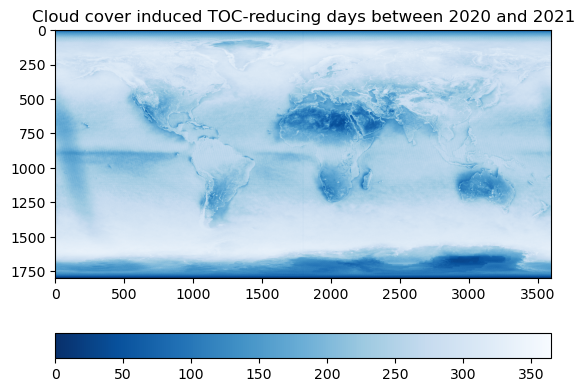

In [20]:
plt.imshow(cc_flip,cmap = reversed_map,vmin=0,vmax=365)
plt.title("Cloud cover induced TOC-reducing days between 2020 and 2021")
plt.colorbar(orientation="horizontal")
plt.show()
#plt.savefig(r"save your map",dpi=300)